For U-net coding and training, i'm following this guide:<br> 
https://medium.com/@vipul.sarode007/u-net-unleashed-a-step-by-step-guide-on-implementing-and-training-your-own-segmentation-model-in-a38741776968

## Part 1. Data loading and preparation

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt

# import sys
# sys.path.insert(1, '/kaggle/input/unetscratch')  
import unet

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout

1. Load images

In [40]:
image_dir = '../data/u-net-data/512_jpg/training/'
mask_dir = '../data/u-net-data/512_jpg/training-labels/'

imgsort = sorted(os.listdir(image_dir))
masksort = sorted(os.listdir(mask_dir))


In [41]:
len(imgsort), len(masksort)

(110, 110)

In [24]:
imgsort

['20250527212624.jpg',
 '20250527212634.jpg',
 '20250527212639.jpg',
 '20250527212643.jpg',
 '20250527212651.jpg',
 '20250527212654.jpg',
 '20250527212658.jpg',
 '20250527212726.jpg',
 '20250527212731.jpg',
 '20250527212735.jpg',
 '20250527212749.jpg',
 '20250527212753.jpg',
 '20250527212756.jpg',
 '20250527212800.jpg',
 '20250527212803.jpg',
 '20250527212807.jpg',
 '20250527212915.jpg',
 '20250527212943.jpg',
 '20250527212947.jpg',
 '20250527213001.jpg',
 '20250527213020.jpg',
 '20250527213024.jpg',
 '20250527213048.jpg',
 '20250527213105.jpg',
 '20250527213123.jpg',
 '20250527213139.jpg',
 '20250527213208.jpg',
 '20250527213347.jpg',
 '20250527213402.jpg',
 '20250527213410.jpg',
 '20250527213426.jpg',
 '20250527213445.jpg',
 '20250527213635.jpg',
 '20250527213654.jpg',
 '20250527213658.jpg',
 '20250527213705.jpg',
 '20250527213729.jpg',
 '20250527213742.jpg',
 '20250527213809.jpg',
 '20250527213817.jpg',
 '20250527213831.jpg',
 '20250527213835.jpg',
 '20250527213921.jpg',
 '202505280

In [42]:
#loading the images, converting them to grayscale and resizing them to (256,256)
def load_images(imgsort, masksort, image_dir, mask_dir):
    images, masks = [], []

    for img, msk in tqdm(zip(imgsort, masksort), total = len(imgsort), desc = 'Loading Images and Masks'):
        image = cv2.imread(image_dir + img, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_dir + msk, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (512,512))
        mask = cv2.resize(mask, (512,512))

#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        images.append(image)
        masks.append(mask)

        del image, mask
        
    return images, masks
    
images, masks = load_images(imgsort, masksort, image_dir, mask_dir)



Loading Images and Masks: 100%|██████████| 110/110 [00:00<00:00, 650.70it/s]


In [43]:
#Visualizing Images and Masks for Sanity
def plot_image_with_mask(image_list, mask_list, num_pairs = 4):
    plt.figure(figsize = (18,9))
    for i in range(num_pairs):
        idx = random.randint(0, len(image_list))
        img = image_list[idx]
        mask = mask_list[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num_pairs + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask

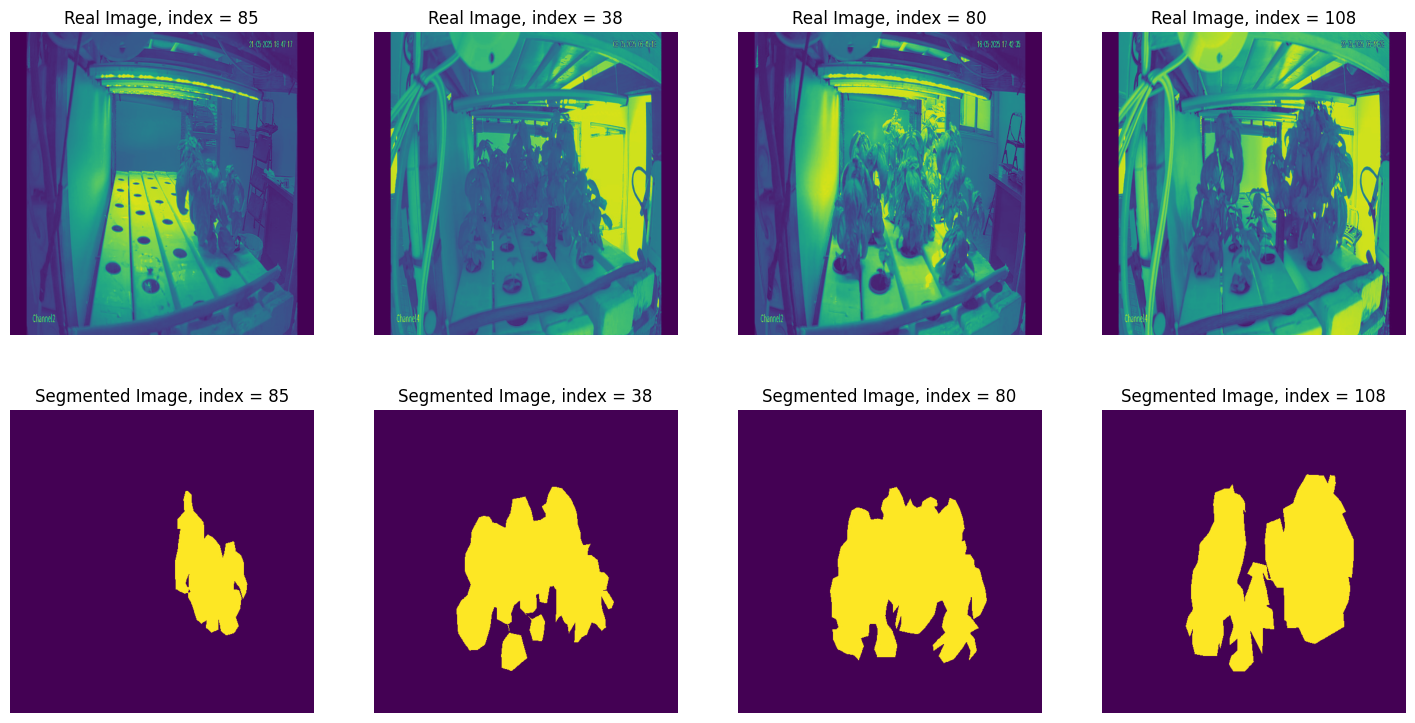

In [44]:
plot_image_with_mask(images, masks, num_pairs = 4)

2. Converting the images to tensors

In [45]:
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list),  dtype = tf.float32))/255
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype= tf.float32))/255
    return tensor_images, tensor_masks

In [46]:
images, masks = to_tensor(images, masks)

3. Split into train test and validation

In [47]:
train_split = tf.cast(tf.round(len(images)*0.6) - 1, dtype = tf.int32)
test_val_split = tf.cast(tf.round(len(images)*0.2), dtype = tf.int32)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 65 and 65 respectively
The length of images and masks for validation is 22 and 22 respectively
The length of images and masks for testing is 23 and 23 respectively


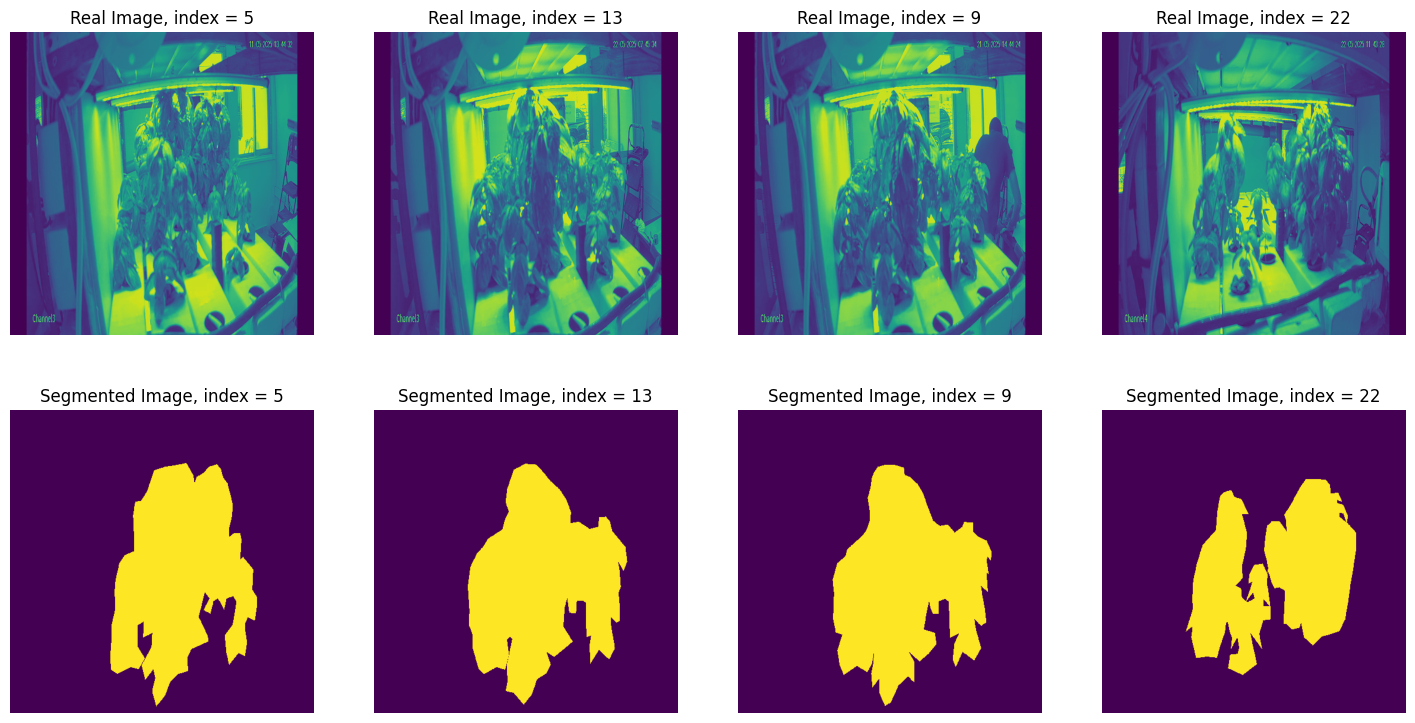

In [50]:
plot_image_with_mask(images_test, masks_test)

In [51]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 32

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

4. Evaluation metrics

In [52]:


# Setting dice coefficient to evaluate our model
def dice_coeff(y_true, y_pred, smooth = 1):
    intersection = K.sum(y_true*y_pred, axis = -1)
    union = K.sum(y_true, axis = -1) + K.sum(y_pred, axis = -1)
    dice_coeff = (2*intersection+smooth) / (union + smooth)
    return dice_coeff



In [ ]:


with strategy.scope():
    unet = unet()
    unet.compile(loss = 'binary_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy', dice_coeff])
unet.summary()

